# Markov Chain Simulation

## Introduction

A **Markov chain** is a stochastic process that satisfies the **Markov property**: the future state depends only on the current state, not on the sequence of events that preceded it. This "memoryless" property makes Markov chains powerful tools for modeling systems in physics, biology, economics, and computer science.

## Mathematical Foundation

### Definition

A discrete-time Markov chain is a sequence of random variables $X_0, X_1, X_2, \ldots$ taking values in a finite or countable state space $S$, satisfying:

$$P(X_{n+1} = j \mid X_n = i, X_{n-1} = i_{n-1}, \ldots, X_0 = i_0) = P(X_{n+1} = j \mid X_n = i)$$

This conditional probability is called the **transition probability** and is denoted:

$$p_{ij} = P(X_{n+1} = j \mid X_n = i)$$

### Transition Matrix

For a Markov chain with $N$ states, the transition probabilities are organized into an $N \times N$ **transition matrix** $\mathbf{P}$:

$$\mathbf{P} = \begin{pmatrix} p_{11} & p_{12} & \cdots & p_{1N} \\ p_{21} & p_{22} & \cdots & p_{2N} \\ \vdots & \vdots & \ddots & \vdots \\ p_{N1} & p_{N2} & \cdots & p_{NN} \end{pmatrix}$$

Each row must sum to 1 (stochastic matrix):

$$\sum_{j=1}^{N} p_{ij} = 1 \quad \forall i$$

### Chapman-Kolmogorov Equation

The $n$-step transition probability is given by:

$$p_{ij}^{(n)} = P(X_{m+n} = j \mid X_m = i) = (\mathbf{P}^n)_{ij}$$

### Stationary Distribution

A probability distribution $\boldsymbol{\pi} = (\pi_1, \pi_2, \ldots, \pi_N)$ is a **stationary distribution** if:

$$\boldsymbol{\pi} \mathbf{P} = \boldsymbol{\pi}$$

This means $\boldsymbol{\pi}$ is a left eigenvector of $\mathbf{P}$ with eigenvalue 1.

For an irreducible and aperiodic Markov chain, the stationary distribution exists, is unique, and:

$$\lim_{n \to \infty} p_{ij}^{(n)} = \pi_j$$

regardless of the initial state $i$.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

# Set random seed for reproducibility
np.random.seed(42)

## Example: Weather Model

Consider a simple weather model with three states:
- State 0: Sunny
- State 1: Cloudy
- State 2: Rainy

We define a transition matrix based on typical weather patterns.

In [4]:
# Define states
states = ['Sunny', 'Cloudy', 'Rainy']
n_states = len(states)

# Define transition matrix
# P[i,j] = probability of transitioning from state i to state j
P = np.array([
    [0.7, 0.2, 0.1],  # From Sunny
    [0.3, 0.4, 0.3],  # From Cloudy
    [0.2, 0.3, 0.5]   # From Rainy
])

# Verify it's a valid stochastic matrix
print("Transition Matrix P:")
print(P)
print(f"\nRow sums: {P.sum(axis=1)}")
print("All rows sum to 1:", np.allclose(P.sum(axis=1), 1))

Transition Matrix P:
[[0.7 0.2 0.1]
 [0.3 0.4 0.3]
 [0.2 0.3 0.5]]

Row sums: [1. 1. 1.]
All rows sum to 1: True


## Markov Chain Simulation

We now implement a function to simulate the Markov chain and visualize its behavior.

In [5]:
def simulate_markov_chain(P, initial_state, n_steps):
    """
    Simulate a Markov chain.
    
    Parameters:
    -----------
    P : ndarray
        Transition matrix (n_states x n_states)
    initial_state : int
        Starting state index
    n_steps : int
        Number of steps to simulate
        
    Returns:
    --------
    states_history : list
        Sequence of visited states
    """
    n_states = P.shape[0]
    current_state = initial_state
    states_history = [current_state]
    
    for _ in range(n_steps):
        # Sample next state from transition probabilities
        next_state = np.random.choice(n_states, p=P[current_state])
        states_history.append(next_state)
        current_state = next_state
    
    return states_history

# Simulate the chain
n_steps = 1000
initial_state = 0  # Start with Sunny
trajectory = simulate_markov_chain(P, initial_state, n_steps)

print(f"First 20 states: {[states[s] for s in trajectory[:20]]}")

First 20 states: ['Sunny', 'Sunny', 'Rainy', 'Rainy', 'Rainy', 'Sunny', 'Sunny', 'Sunny', 'Cloudy', 'Cloudy', 'Rainy', 'Sunny', 'Rainy', 'Rainy', 'Cloudy', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Sunny']


## Computing the Stationary Distribution

### Analytical Solution

We find $\boldsymbol{\pi}$ by solving $\boldsymbol{\pi} \mathbf{P} = \boldsymbol{\pi}$ subject to $\sum_i \pi_i = 1$.

This is equivalent to finding the left eigenvector of $\mathbf{P}$ corresponding to eigenvalue 1.

In [6]:
def compute_stationary_distribution(P):
    """
    Compute the stationary distribution of a Markov chain.
    
    Parameters:
    -----------
    P : ndarray
        Transition matrix
        
    Returns:
    --------
    pi : ndarray
        Stationary distribution
    """
    n = P.shape[0]
    
    # Solve (P^T - I) * pi = 0 with constraint sum(pi) = 1
    # Augment the system with the normalization constraint
    A = np.vstack([P.T - np.eye(n), np.ones(n)])
    b = np.zeros(n + 1)
    b[-1] = 1
    
    # Solve using least squares
    pi, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    
    return pi

# Compute analytical stationary distribution
pi_analytical = compute_stationary_distribution(P)
print("Analytical Stationary Distribution:")
for i, state in enumerate(states):
    print(f"  {state}: {pi_analytical[i]:.4f}")

Analytical Stationary Distribution:
  Sunny: 0.4565
  Cloudy: 0.2826
  Rainy: 0.2609


### Empirical Estimation

We can also estimate the stationary distribution from the simulation by computing the fraction of time spent in each state.

In [7]:
# Compute empirical distribution from simulation
trajectory_array = np.array(trajectory)
pi_empirical = np.array([np.sum(trajectory_array == i) for i in range(n_states)]) / len(trajectory)

print("Empirical Stationary Distribution (from simulation):")
for i, state in enumerate(states):
    print(f"  {state}: {pi_empirical[i]:.4f}")

print(f"\nMaximum absolute error: {np.max(np.abs(pi_analytical - pi_empirical)):.4f}")

Empirical Stationary Distribution (from simulation):
  Sunny: 0.4715
  Cloudy: 0.2597
  Rainy: 0.2687

Maximum absolute error: 0.0229


## Convergence Analysis

We examine how the state distribution converges to the stationary distribution over time.

In [8]:
def compute_distribution_over_time(P, initial_dist, n_steps):
    """
    Compute the probability distribution at each time step.
    
    Parameters:
    -----------
    P : ndarray
        Transition matrix
    initial_dist : ndarray
        Initial probability distribution
    n_steps : int
        Number of steps
        
    Returns:
    --------
    distributions : ndarray
        Distribution at each time step (n_steps+1 x n_states)
    """
    distributions = [initial_dist]
    current_dist = initial_dist.copy()
    
    for _ in range(n_steps):
        current_dist = current_dist @ P
        distributions.append(current_dist.copy())
    
    return np.array(distributions)

# Start from different initial distributions
initial_distributions = [
    np.array([1.0, 0.0, 0.0]),  # Start in Sunny
    np.array([0.0, 1.0, 0.0]),  # Start in Cloudy
    np.array([0.0, 0.0, 1.0])   # Start in Rainy
]

n_convergence_steps = 50
convergence_results = []

for init_dist in initial_distributions:
    result = compute_distribution_over_time(P, init_dist, n_convergence_steps)
    convergence_results.append(result)

## Visualization

We create a comprehensive visualization showing:
1. The transition matrix as a heatmap
2. A sample trajectory
3. Convergence to stationary distribution
4. Comparison of analytical vs empirical distributions

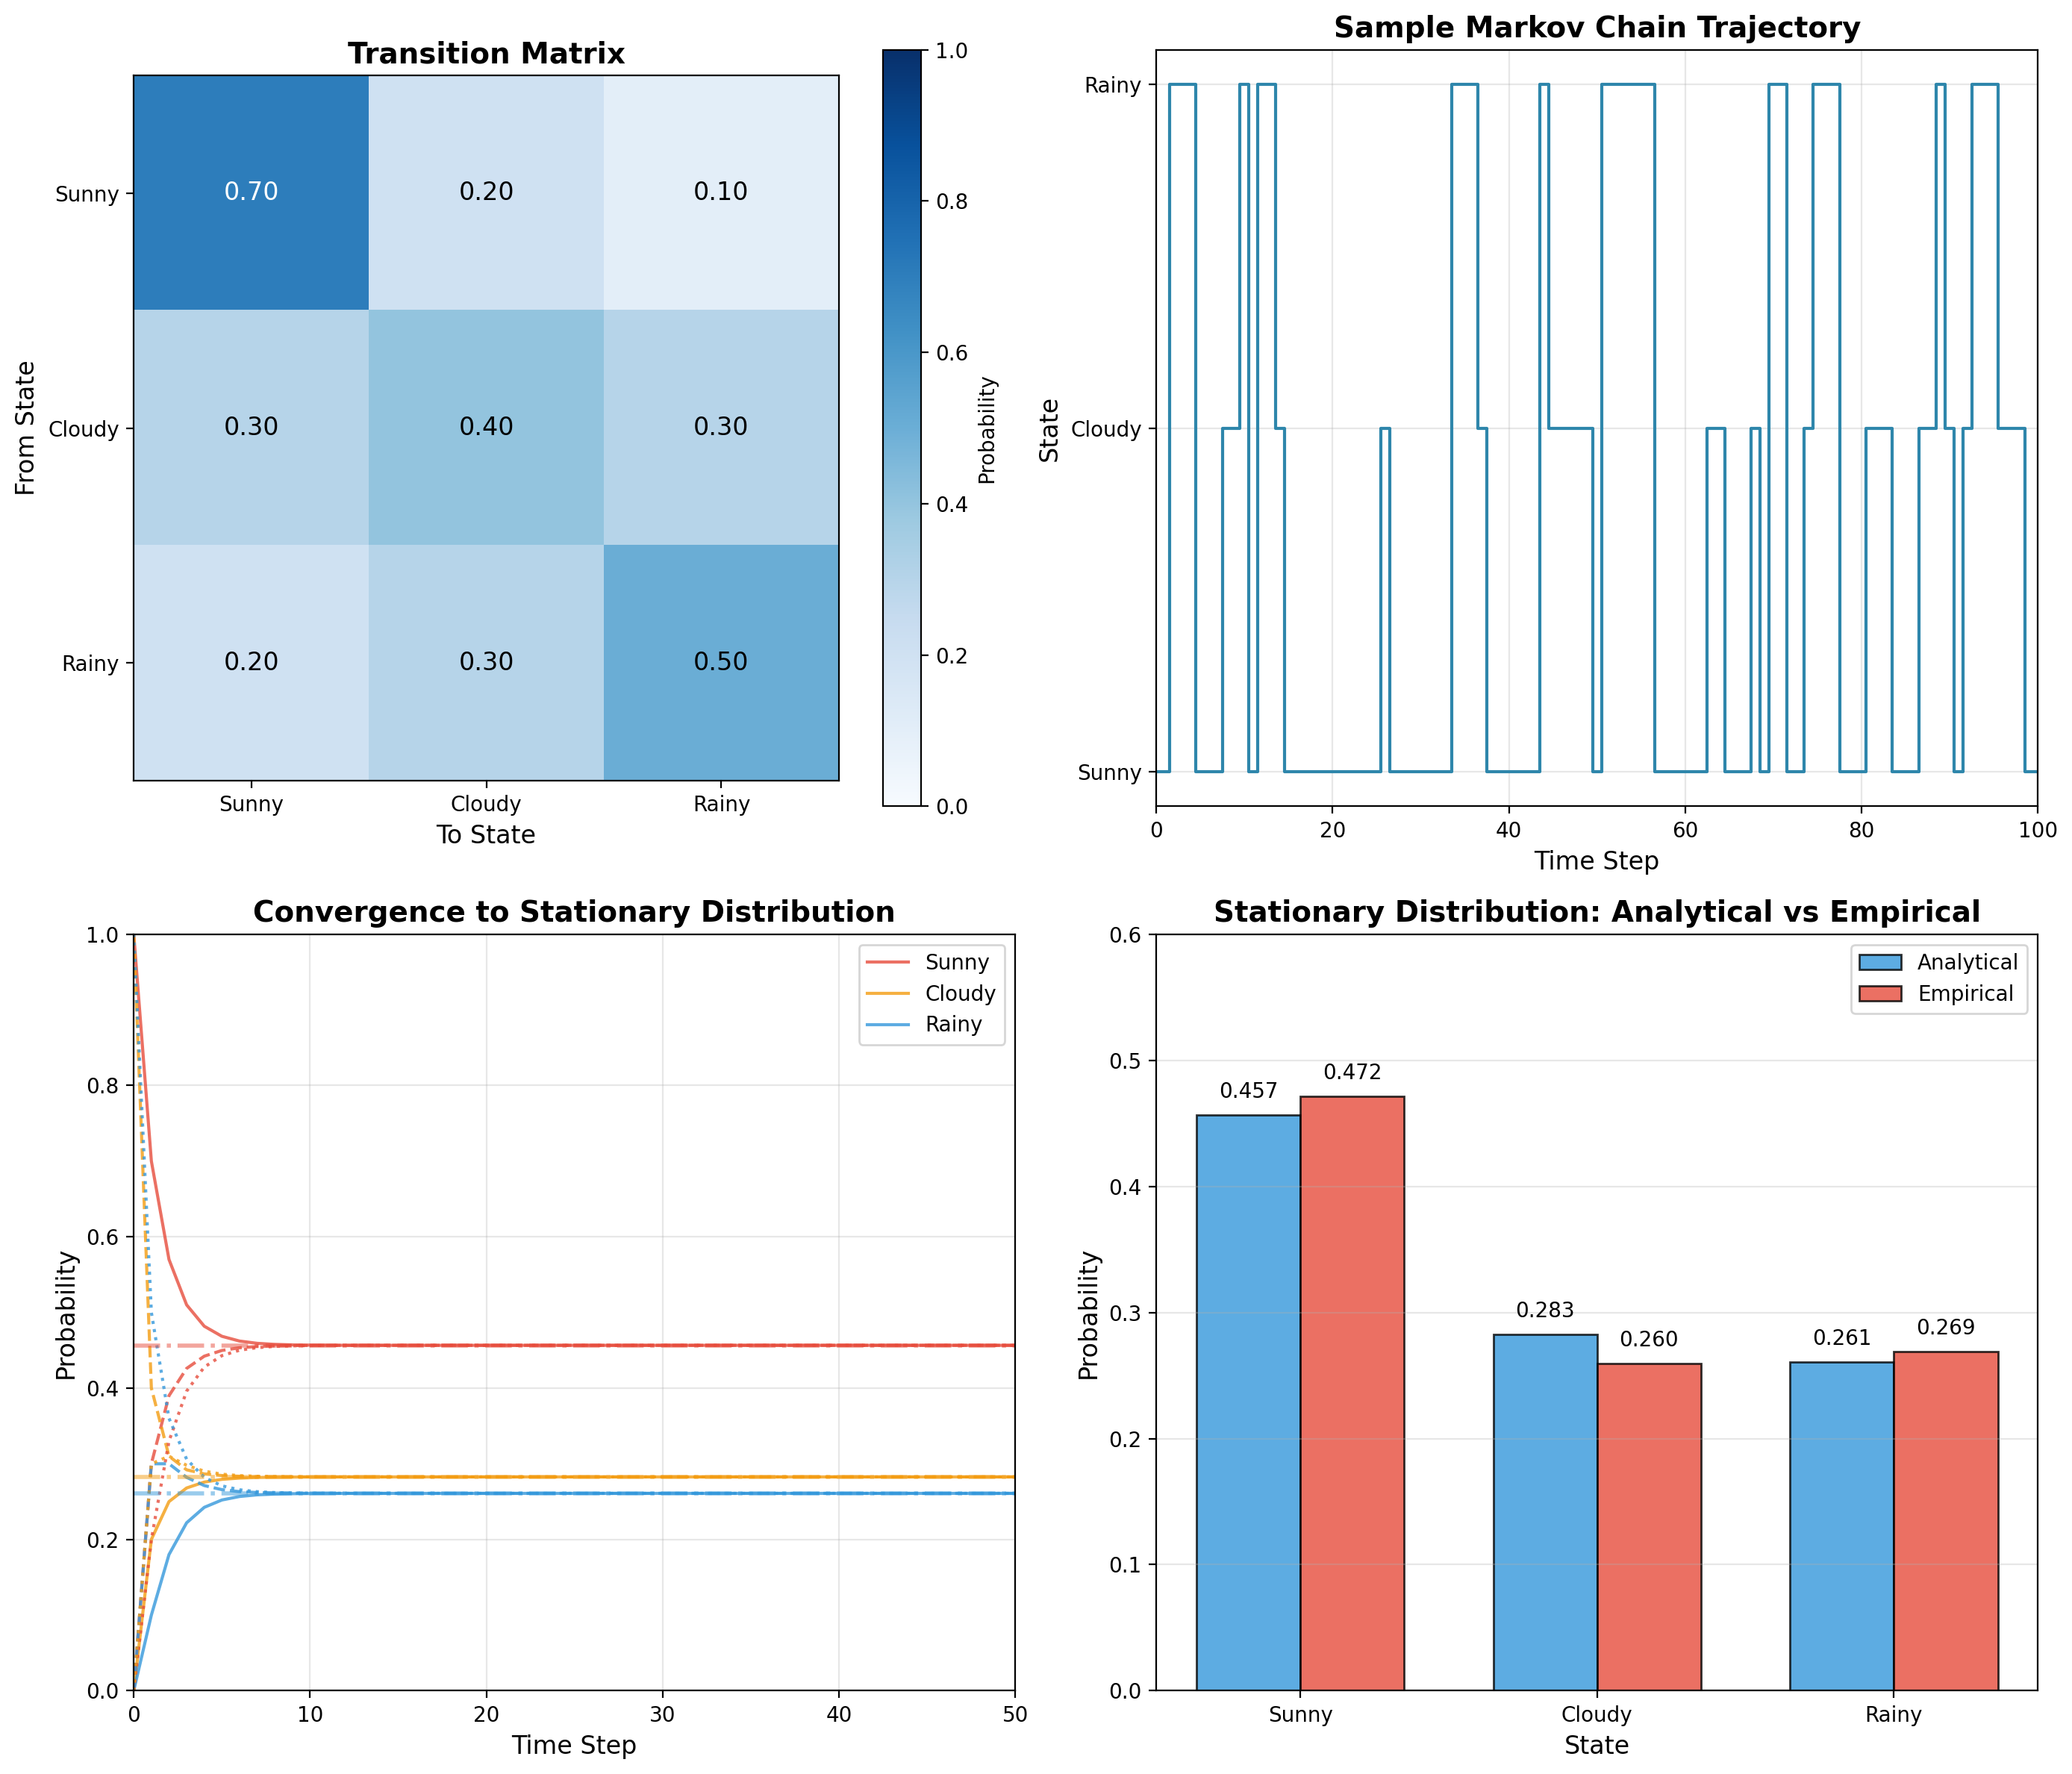


Plot saved to 'plot.png'


In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Transition Matrix Heatmap
ax1 = axes[0, 0]
im = ax1.imshow(P, cmap='Blues', vmin=0, vmax=1)
ax1.set_xticks(range(n_states))
ax1.set_yticks(range(n_states))
ax1.set_xticklabels(states)
ax1.set_yticklabels(states)
ax1.set_xlabel('To State', fontsize=12)
ax1.set_ylabel('From State', fontsize=12)
ax1.set_title('Transition Matrix', fontsize=14, fontweight='bold')

# Add text annotations
for i in range(n_states):
    for j in range(n_states):
        text = ax1.text(j, i, f'{P[i, j]:.2f}',
                       ha='center', va='center', fontsize=12,
                       color='white' if P[i, j] > 0.5 else 'black')

plt.colorbar(im, ax=ax1, label='Probability')

# Plot 2: Sample Trajectory
ax2 = axes[0, 1]
plot_steps = 100
ax2.step(range(plot_steps + 1), trajectory[:plot_steps + 1], where='mid', 
         linewidth=1.5, color='#2E86AB')
ax2.set_yticks(range(n_states))
ax2.set_yticklabels(states)
ax2.set_xlabel('Time Step', fontsize=12)
ax2.set_ylabel('State', fontsize=12)
ax2.set_title('Sample Markov Chain Trajectory', fontsize=14, fontweight='bold')
ax2.set_xlim(0, plot_steps)
ax2.grid(True, alpha=0.3)

# Plot 3: Convergence to Stationary Distribution
ax3 = axes[1, 0]
colors = ['#E74C3C', '#F39C12', '#3498DB']
linestyles = ['-', '--', ':']

for idx, (result, init_name) in enumerate(zip(convergence_results, states)):
    for state_idx in range(n_states):
        if idx == 0:  # Only label once
            label = states[state_idx]
        else:
            label = None
        ax3.plot(result[:, state_idx], 
                color=colors[state_idx], 
                linestyle=linestyles[idx],
                linewidth=1.5,
                label=label,
                alpha=0.8)

# Add horizontal lines for stationary distribution
for state_idx in range(n_states):
    ax3.axhline(y=pi_analytical[state_idx], color=colors[state_idx], 
               linestyle='-.', alpha=0.5, linewidth=2)

ax3.set_xlabel('Time Step', fontsize=12)
ax3.set_ylabel('Probability', fontsize=12)
ax3.set_title('Convergence to Stationary Distribution', fontsize=14, fontweight='bold')
ax3.legend(loc='upper right')
ax3.set_xlim(0, n_convergence_steps)
ax3.set_ylim(0, 1)
ax3.grid(True, alpha=0.3)

# Plot 4: Comparison of Analytical vs Empirical Distribution
ax4 = axes[1, 1]
x = np.arange(n_states)
width = 0.35

bars1 = ax4.bar(x - width/2, pi_analytical, width, label='Analytical', 
               color='#3498DB', alpha=0.8, edgecolor='black')
bars2 = ax4.bar(x + width/2, pi_empirical, width, label='Empirical', 
               color='#E74C3C', alpha=0.8, edgecolor='black')

ax4.set_xlabel('State', fontsize=12)
ax4.set_ylabel('Probability', fontsize=12)
ax4.set_title('Stationary Distribution: Analytical vs Empirical', 
             fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(states)
ax4.legend()
ax4.set_ylim(0, 0.6)
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars1, pi_analytical):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{val:.3f}', ha='center', va='bottom', fontsize=10)
for bar, val in zip(bars2, pi_empirical):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{val:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('plot.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("\nPlot saved to 'plot.png'")

## Theoretical Verification

### Verifying Stationarity

We verify that $\boldsymbol{\pi} \mathbf{P} = \boldsymbol{\pi}$:

In [10]:
# Verify stationarity condition
pi_P = pi_analytical @ P
print("Verification of πP = π:")
print(f"π:    {pi_analytical}")
print(f"πP:   {pi_P}")
print(f"Equal: {np.allclose(pi_analytical, pi_P)}")

Verification of πP = π:
π:    [0.45652174 0.2826087  0.26086957]
πP:   [0.45652174 0.2826087  0.26086957]
Equal: True


### Long-term Behavior

For large $n$, all rows of $\mathbf{P}^n$ should converge to the stationary distribution:

In [11]:
# Compute P^n for large n
P_100 = np.linalg.matrix_power(P, 100)

print("P^100 (should have identical rows equal to π):")
print(P_100)
print(f"\nStationary distribution π: {pi_analytical}")
print(f"\nAll rows equal to π: {np.allclose(P_100, pi_analytical)}")

P^100 (should have identical rows equal to π):
[[0.45652174 0.2826087  0.26086957]
 [0.45652174 0.2826087  0.26086957]
 [0.45652174 0.2826087  0.26086957]]

Stationary distribution π: [0.45652174 0.2826087  0.26086957]

All rows equal to π: True


## Conclusion

This notebook demonstrated the fundamental concepts of Markov chains:

1. **Transition matrices** encode the probabilistic dynamics of the system
2. **Simulations** can be performed by sampling from transition probabilities
3. **Stationary distributions** can be computed analytically as eigenvectors or estimated empirically
4. **Convergence** to the stationary distribution occurs regardless of initial conditions for irreducible, aperiodic chains

The simulation results closely match the analytical predictions, validating both the implementation and the theoretical foundations of Markov chain theory.